In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [6]:
file_name = 'pre_processado_completo.csv'

df = pd.read_csv(file_name, header=0, error_bad_lines=False, warn_bad_lines=False, low_memory=False)

In [7]:
df.head()

,city,state,country,shape,duration_m,comments,latitude,longitude,date
0,san marcos,tx,us,cylinder,45.000000,This event took place in early fall around 194...,29.883056,-97.941111,1949-10-10
1,lackland afb,tx,NaN,light,120.000000,1949 Lackland AFB&#44 TX. Lights racing acros...,29.384210,-98.581082,1949-10-10
2,chester (uk/england),NaN,gb,circle,0.333333,Green/Orange circular disc over Chester&#44 En...,53.200000,-2.916667,1955-10-10
3,edna,tx,us,circle,0.333333,My older brother and twin sister were leaving ...,28.978333,-96.645833,1956-10-10
4,kaneohe,hi,us,light,15.000000,AS a Marine 1st Lt. flying an FJ4B fighter/att...,21.418056,-157.803611,1960-10-10


In [8]:
# define um array com as latitudes e longitudes

lat_lon = np.array(df[['longitude', 'latitude']]).astype(float)
print(len(lat_lon))
print(lat_lon)

88673
[[-97.9411111  29.8830556]
 [-98.581082   29.38421  ]
 [ -2.916667   53.2      ]
 ...
 [-97.4777778  35.6527778]
 [-82.6958333  34.3769444]
 [-80.1436111  26.1219444]]


### Analise por país

In [9]:
# define uma lista com os estados, e calcula o peso de cada estado de acordo com a quantidade de avistamentos, pelo método count

countrys = list(df['country'])
pesos_c = [countrys.count(c) for c in countrys]

In [10]:
scaler = MinMaxScaler()

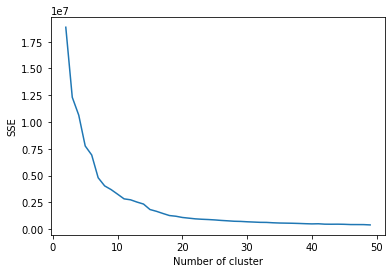

In [185]:
# aplica o elbow criteria

sse = {}
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(scaler.fit_transform(lat_lon), sample_weight=pesos_c)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

### Visto que o range para o Elbow Criteria foi grande, o número adequado de clusters está entre 5 e 25
#### A soma dos erros quadráticos não apresenta decaimento significante a partir desses valores, logo o gasto computacional para k_clusters maiores não se torna viável

### Para definir o melhor valor nesse range, foi utilizado o Coeficiente de Silhouette
#### quanto maior o coeficiente, menor a distância intracluster e maior a distância intercluster

In [186]:
# aplica o coeficiente de silhouette

for k in range(5, 25):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(scaler.fit_transform(lat_lon), sample_weight=pesos_c)
    label = kmeans.labels_
    sil_coeff = metrics.silhouette_score(scaler.fit_transform(lat_lon), label, metric='euclidean')
    print("Para n_clusters={}, o coeficiente de  Silhouette {}".format(k, sil_coeff))

Para n_clusters=5, o coeficiente de  Silhouette 0.46598316840529724
Para n_clusters=6, o coeficiente de  Silhouette 0.4897882658227698
Para n_clusters=7, o coeficiente de  Silhouette 0.5258168934605912
Para n_clusters=8, o coeficiente de  Silhouette 0.5313451159941194
Para n_clusters=9, o coeficiente de  Silhouette 0.49102312490102323
Para n_clusters=10, o coeficiente de  Silhouette 0.4595092735305331
Para n_clusters=11, o coeficiente de  Silhouette 0.4810090414515804
Para n_clusters=12, o coeficiente de  Silhouette 0.5036531951849171
Para n_clusters=13, o coeficiente de  Silhouette 0.5085155991356703
Para n_clusters=14, o coeficiente de  Silhouette 0.509036771337527
Para n_clusters=15, o coeficiente de  Silhouette 0.49886548703997974
Para n_clusters=16, o coeficiente de  Silhouette 0.47910414097105325
Para n_clusters=17, o coeficiente de  Silhouette 0.5192344391342331
Para n_clusters=18, o coeficiente de  Silhouette 0.5173712567867976
Para n_clusters=19, o coeficiente de  Silhouette 0

### De acordo com o Coeficiente de Silhouette o número adequado de clusters é em torno de 8

In [11]:
# aplica o algoritmo kmeans, utilizando os pesos e normalizando os valores

kmeans = KMeans(n_clusters=8, max_iter=2000)
kmeans.fit(scaler.fit_transform(lat_lon), sample_weight=pesos_c)
lat_lon_scaled = np.array(scaler.fit_transform(lat_lon))
lat_lon_scaled

array([[0.22167546, 0.72476095],
       [0.21987323, 0.72155423],
       [0.4892746 , 0.87464866],
       ...,
       [0.22298025, 0.7618503 ],
       [0.26460781, 0.7536489 ],
       [0.27179515, 0.70058349]])

In [12]:
centers = kmeans.cluster_centers_
centers

array([[0.24588871, 0.79675021],
       [0.48624662, 0.50484434],
       [0.52672614, 0.84103309],
       [0.16970532, 0.76141071],
       [0.81945978, 0.56303158],
       [0.15443586, 0.83536349],
       [0.28452223, 0.79449842],
       [0.25168906, 0.73475593]])

In [13]:
locations = kmeans.labels_.astype(float)
print(len(locations))
locations

88673


array([7., 7., 2., ..., 7., 7., 7.])

Text(0, 0.5, 'Longitude')

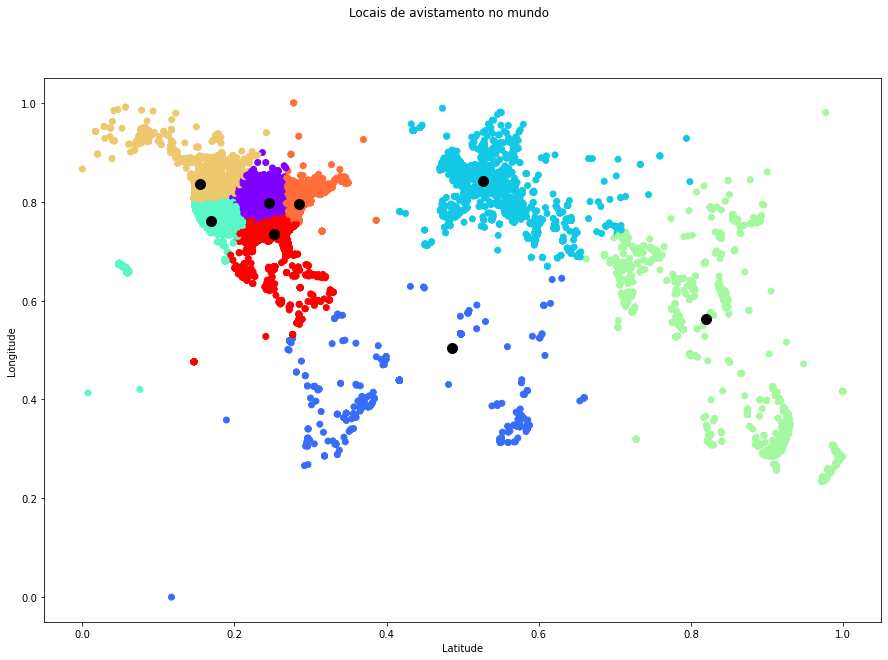

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(lat_lon_scaled[:, 0], lat_lon_scaled[:, 1], c=locations, cmap='rainbow')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=100)
fig.suptitle('Locais de avistamento no mundo')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

Text(0, 0.5, 'Longitude')

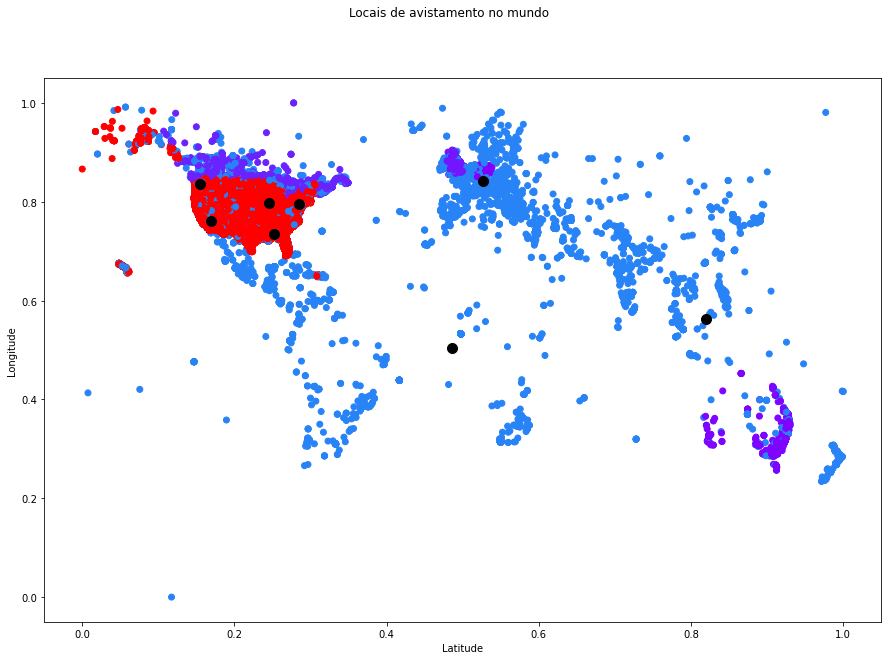

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(lat_lon_scaled[:, 0], lat_lon_scaled[:, 1], c=pesos_c, cmap='rainbow')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=100)
fig.suptitle('Locais de avistamento no mundo')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

In [16]:
geolocator = Nominatim(user_agent="geoapiExercises")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [17]:
centers_notscaled = scaler.inverse_transform(centers)
centers_notscaled = centers_notscaled.tolist()

for i in range(len(centers_notscaled)):
    centers_notscaled[i][0], centers_notscaled[i][1] = centers_notscaled[i][1], centers_notscaled[i][0]

centers_notscaled = [tuple(center) for center in centers_notscaled]
centers_notscaled

[(41.081902626771075, -89.34298617725203),
 (-4.327776928188429, -3.9919026318325552),
 (47.97066952806195, 10.382372490627283),
 (35.584393143746794, -116.39570310871636),
 (4.723990172361304, 114.3320774966908),
 (47.08869200330503, -121.81788699815908),
 (40.731608241894136, -75.62422324789804),
 (31.43790238759044, -87.28328127727826)]

In [18]:
address = [reverse(loc) for loc in centers_notscaled]

In [19]:
centers_countrys = []
for i in range(12):
    try:
        centers_countrys.append(address[i].raw['address']['country'])
    except:
        centers_countrys.append('NULL')
centers_countrys

['United States',
 'NULL',
 'Deutschland',
 'United States',
 'NULL',
 'United States',
 'United States',
 'United States',
 'NULL',
 'NULL',
 'NULL',
 'NULL']

In [20]:
locations = list(locations)
locations = [int(item) for item in locations]
centers_countrys_all = [centers_countrys[loc] for loc in locations]
centers_countrys_all

['United States',
 'United States',
 'Deutschland',
 'United States',
 'United States',
 'United States',
 'Deutschland',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'NULL',
 'United States',
 'Deutschland',
 'United States',
 'United States',
 'United States',
 'Deutschland',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'NULL',
 'United States',
 'United States',
 'United States',
 'Deutschland',
 'United States',
 'NULL',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'NULL',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 '

In [22]:
pd.set_option("max_colwidth", 120)
df['pesos'] = pesos_c
df['k-countrys'] = centers_countrys_all
df['k-centers'] = locations
df[['country', 'pesos', 'k-countrys', 'k-centers']].head(15)

,country,pesos,k-countrys,k-centers
0,us,70290,United States,7
1,NaN,12362,United States,7
2,gb,2050,Deutschland,2
3,us,70290,United States,7
4,us,70290,United States,3
5,us,70290,United States,6
6,gb,2050,Deutschland,2
7,us,70290,United States,6
8,us,70290,United States,7
9,us,70290,United States,7
